<a href="https://colab.research.google.com/github/Joshuajee/AI-ML-PROJECTS/blob/master/Topic%20Modelling%20on%20Financial%20Posts%20from%20Redit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [84]:
!pip install bertopic

** **
## Step 1: Loading the Data
** **
The data was collected manually from twenty two financial subreddit and saved in a csv format to my github repo.

In [85]:
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics.pairwise import cosine_distances, cosine_similarity
from scipy.cluster.hierarchy import dendrogram, linkage

# BERTopic model
from bertopic import BERTopic
# Dimension reduction
from umap import UMAP
# Clustering
from hdbscan import HDBSCAN
from sklearn.cluster import KMeans
# Count vectorization
from sklearn.feature_extraction.text import CountVectorizer
# Sentence transformer
from sentence_transformers import SentenceTransformer

In [86]:
def get_redit_data_from_github():
  file_path = "https://raw.githubusercontent.com/Joshuajee/AI-ML-PROJECTS/master/data/reddit/reddit_financial_data.csv"
  reponse = requests.get(file_path)
  if reponse.status_code == 200:
    with open("reddit_financial_data.csv", "wb") as f:
      f.write(reponse.content)
    return pd.read_csv("reddit_financial_data.csv", sep=",")
  else:
    raise Exception("Error downloading", reponse.status_code)


In [87]:
reddit_data = get_redit_data_from_github()
reddit_data

Unnamed: 0       id  subreddit  \
0               0  1jd5ybv    finance   
1               1  1jfd4r2    finance   
2               2  1j7s07n    finance   
3               3  1j4i8hv    finance   
4               4  1j2c1rd    finance   
...           ...      ...        ...   
12870       12870  1ipd9px  dividends   
12871       12871  1iq6xxy  dividends   
12872       12872  1iq6e30  dividends   
12873       12873  1ipz087  dividends   
12874       12874  1ipcocf  dividends   

                                                   title  \
0      Moronic Monday - March 17, 2025 - Your Weekly ...   
1      $1.4bn is a lot to fall through the cracks, ev...   
2      Moronic Monday - March 10, 2025 - Your Weekly ...   
3      Goldman, JPMorgan Among Banks Offering More Ru...   
4      Moronic Monday - March 03, 2025 - Your Weekly ...   
...                                                  ...   
12870  1,000,000.00 in a schwab money market fund mak...   
12871              New Investor interested in Dividends.   
12872                          Survey for Research-Paper   
12873                                       PBR-A vs. EC   
12874                                     The "VOO" sub.   

                                                    text  \
0      This is your safe place for questions on finan...   
1      Interesting post on Tesla's accounting (from t...   
2      This is your safe place for questions on finan...   
3      The Trump administration isn’t the only one lo...   
4      This is your safe place for questions on finan...   
...                                                  ...   
12870  Super interested in dividend stocks but am a c...   
12871  I'm new to investing and just had my first kid...   
12872  Hi \nI’m conducting a  survey on the speed, ac...   
12873  The yields here look very interesting. What is...   
12874  I know I already said this, but really gets me...   

                                                     url  score  num_comments  \
0      https://www.reddit.com/r/finance/comments/1jd5...      3            20   
1      https://www.ft.com/content/62df8d8d-31f2-445e-...   1206            89   
2      https://www.reddit.com/r/finance/comments/1j7s...      5            21   
3      https://www.bloomberg.com/news/articles/2025-0...    118            10   
4      https://www.reddit.com/r/finance/comments/1j2c...      3            28   
...                                                  ...    ...           ...   
12870  https://www.reddit.com/r/dividends/comments/1i...    161            93   
12871  https://www.reddit.com/r/dividends/comments/1i...      0            10   
12872  https://www.reddit.com/r/dividends/comments/1i...      0             1   
12873  https://www.reddit.com/r/dividends/comments/1i...      3             5   
12874  https://www.reddit.com/r/dividends/comments/1i...    111            58   

        created_utc  
0      1.742191e+09  
1      1.742433e+09  
2      1.741586e+09  
3      1.741220e+09  
4      1.740982e+09  
...             ...  
12870  1.739547e+09  
12871  1.739642e+09  
12872  1.739640e+09  
12873  1.739617e+09  
12874  1.739546e+09  

[12875 rows x 9 columns]

** **
## Step 2: Data Cleaning
** **

The reddit post data contains multiple columns, but since this is an NLP task only the text and title columns are useful for our Topic modeling task the other columns will be ignored.

1. Join the title and the text columns
2. Remove punctuations and special characters.




In [88]:
# Join the title and text columns in a new content column
reddit_data['content'] = reddit_data['title'] + ' ' + reddit_data['text']
reddit_data

Unnamed: 0       id  subreddit  \
0               0  1jd5ybv    finance   
1               1  1jfd4r2    finance   
2               2  1j7s07n    finance   
3               3  1j4i8hv    finance   
4               4  1j2c1rd    finance   
...           ...      ...        ...   
12870       12870  1ipd9px  dividends   
12871       12871  1iq6xxy  dividends   
12872       12872  1iq6e30  dividends   
12873       12873  1ipz087  dividends   
12874       12874  1ipcocf  dividends   

                                                   title  \
0      Moronic Monday - March 17, 2025 - Your Weekly ...   
1      $1.4bn is a lot to fall through the cracks, ev...   
2      Moronic Monday - March 10, 2025 - Your Weekly ...   
3      Goldman, JPMorgan Among Banks Offering More Ru...   
4      Moronic Monday - March 03, 2025 - Your Weekly ...   
...                                                  ...   
12870  1,000,000.00 in a schwab money market fund mak...   
12871              New Investor interested in Dividends.   
12872                          Survey for Research-Paper   
12873                                       PBR-A vs. EC   
12874                                     The "VOO" sub.   

                                                    text  \
0      This is your safe place for questions on finan...   
1      Interesting post on Tesla's accounting (from t...   
2      This is your safe place for questions on finan...   
3      The Trump administration isn’t the only one lo...   
4      This is your safe place for questions on finan...   
...                                                  ...   
12870  Super interested in dividend stocks but am a c...   
12871  I'm new to investing and just had my first kid...   
12872  Hi \nI’m conducting a  survey on the speed, ac...   
12873  The yields here look very interesting. What is...   
12874  I know I already said this, but really gets me...   

                                                     url  score  num_comments  \
0      https://www.reddit.com/r/finance/comments/1jd5...      3            20   
1      https://www.ft.com/content/62df8d8d-31f2-445e-...   1206            89   
2      https://www.reddit.com/r/finance/comments/1j7s...      5            21   
3      https://www.bloomberg.com/news/articles/2025-0...    118            10   
4      https://www.reddit.com/r/finance/comments/1j2c...      3            28   
...                                                  ...    ...           ...   
12870  https://www.reddit.com/r/dividends/comments/1i...    161            93   
12871  https://www.reddit.com/r/dividends/comments/1i...      0            10   
12872  https://www.reddit.com/r/dividends/comments/1i...      0             1   
12873  https://www.reddit.com/r/dividends/comments/1i...      3             5   
12874  https://www.reddit.com/r/dividends/comments/1i...    111            58   

        created_utc                                            content  
0      1.742191e+09  Moronic Monday - March 17, 2025 - Your Weekly ...  
1      1.742433e+09  $1.4bn is a lot to fall through the cracks, ev...  
2      1.741586e+09  Moronic Monday - March 10, 2025 - Your Weekly ...  
3      1.741220e+09  Goldman, JPMorgan Among Banks Offering More Ru...  
4      1.740982e+09  Moronic Monday - March 03, 2025 - Your Weekly ...  
...             ...                                                ...  
12870  1.739547e+09  1,000,000.00 in a schwab money market fund mak...  
12871  1.739642e+09  New Investor interested in Dividends. I'm new ...  
12872  1.739640e+09  Survey for Research-Paper Hi \nI’m conducting ...  
12873  1.739617e+09  PBR-A vs. EC The yields here look very interes...  
12874  1.739546e+09  The "VOO" sub. I know I already said this, but...  

[12875 rows x 10 columns]

In [89]:
# Create a new DataFrame containing only the content column
content_df = reddit_data[['content']].copy()
content_df

content
0      Moronic Monday - March 17, 2025 - Your Weekly ...
1      $1.4bn is a lot to fall through the cracks, ev...
2      Moronic Monday - March 10, 2025 - Your Weekly ...
3      Goldman, JPMorgan Among Banks Offering More Ru...
4      Moronic Monday - March 03, 2025 - Your Weekly ...
...                                                  ...
12870  1,000,000.00 in a schwab money market fund mak...
12871  New Investor interested in Dividends. I'm new ...
12872  Survey for Research-Paper Hi \nI’m conducting ...
12873  PBR-A vs. EC The yields here look very interes...
12874  The "VOO" sub. I know I already said this, but...

[12875 rows x 1 columns]

In [90]:
def preprocess(text):
    text = re.sub(r'http\S+|www\S+', '', text)  # Remove URLs
    text = re.sub(r'[^A-Za-z0-9\s]+', '', text)  # Remove special characters
    text = text.lower()  # Lowercase text
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

In [91]:
# Cleaning the data gotton from reddit as it contains relevant characters
content_df['cleaned_content'] = content_df['content'].apply(preprocess)
content_df

content  \
0      Moronic Monday - March 17, 2025 - Your Weekly ...   
1      $1.4bn is a lot to fall through the cracks, ev...   
2      Moronic Monday - March 10, 2025 - Your Weekly ...   
3      Goldman, JPMorgan Among Banks Offering More Ru...   
4      Moronic Monday - March 03, 2025 - Your Weekly ...   
...                                                  ...   
12870  1,000,000.00 in a schwab money market fund mak...   
12871  New Investor interested in Dividends. I'm new ...   
12872  Survey for Research-Paper Hi \nI’m conducting ...   
12873  PBR-A vs. EC The yields here look very interes...   
12874  The "VOO" sub. I know I already said this, but...   

                                         cleaned_content  
0      moronic monday march 17 2025 your weekly quest...  
1      14bn is a lot to fall through the cracks even ...  
2      moronic monday march 10 2025 your weekly quest...  
3      goldman jpmorgan among banks offering more rus...  
4      moronic monday march 03 2025 your weekly quest...  
...                                                  ...  
12870  100000000 in a schwab money market fund making...  
12871  new investor interested in dividends im new to...  
12872  survey for researchpaper hi im conducting a su...  
12873  pbra vs ec the yields here look very interesti...  
12874  the voo sub i know i already said this but rea...  

[12875 rows x 2 columns]

In [92]:
# Removing stop words
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
nltk.download('punkt_tab')
nltk.download('omw-1.4')
nltk.download('wordnet')
wn = nltk.WordNetLemmatizer()

# Removing stop words from wordlist columns
content_df['cleaned_content_no_sw'] = content_df['cleaned_content'].apply(lambda x: ' '.join([w for w in x.split() if w not in stop_words]))
# Lemmatization
content_df['cleaned_content_lm_no_sw'] = content_df['cleaned_content_no_sw'].apply(lambda x: ' '.join([wn.lemmatize(w) for w in x.split() if w not in stop_words]))
# Create a new column containing the number of words/tokens
content_df['word_count'] = content_df['cleaned_content_lm_no_sw'].apply(lambda x: len(x.split()))
content_df

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


content  \
0      Moronic Monday - March 17, 2025 - Your Weekly ...   
1      $1.4bn is a lot to fall through the cracks, ev...   
2      Moronic Monday - March 10, 2025 - Your Weekly ...   
3      Goldman, JPMorgan Among Banks Offering More Ru...   
4      Moronic Monday - March 03, 2025 - Your Weekly ...   
...                                                  ...   
12870  1,000,000.00 in a schwab money market fund mak...   
12871  New Investor interested in Dividends. I'm new ...   
12872  Survey for Research-Paper Hi \nI’m conducting ...   
12873  PBR-A vs. EC The yields here look very interes...   
12874  The "VOO" sub. I know I already said this, but...   

                                         cleaned_content  \
0      moronic monday march 17 2025 your weekly quest...   
1      14bn is a lot to fall through the cracks even ...   
2      moronic monday march 10 2025 your weekly quest...   
3      goldman jpmorgan among banks offering more rus...   
4      moronic monday march 03 2025 your weekly quest...   
...                                                  ...   
12870  100000000 in a schwab money market fund making...   
12871  new investor interested in dividends im new to...   
12872  survey for researchpaper hi im conducting a su...   
12873  pbra vs ec the yields here look very interesti...   
12874  the voo sub i know i already said this but rea...   

                                   cleaned_content_no_sw  \
0      moronic monday march 17 2025 weekly questions ...   
1      14bn lot fall cracks even tesla interesting po...   
2      moronic monday march 10 2025 weekly questions ...   
3      goldman jpmorgan among banks offering russiali...   
4      moronic monday march 03 2025 weekly questions ...   
...                                                  ...   
12870  100000000 schwab money market fund making 42 s...   
12871  new investor interested dividends im new inves...   
12872  survey researchpaper hi im conducting survey s...   
12873  pbra vs ec yields look interesting thought eit...   
12874  voo sub know already said really gets annoyed ...   

                                cleaned_content_lm_no_sw  word_count  
0      moronic monday march 17 2025 weekly question t...          35  
1      14bn lot fall crack even tesla interesting pos...          28  
2      moronic monday march 10 2025 weekly question t...          35  
3      goldman jpmorgan among bank offering russialin...          63  
4      moronic monday march 03 2025 weekly question t...          35  
...                                                  ...         ...  
12870  100000000 schwab money market fund making 42 s...          63  
12871  new investor interested dividend im new invest...          47  
12872  survey researchpaper hi im conducting survey s...          38  
12873  pbra v ec yield look interesting thought eithe...          17  
12874  voo sub know already said really get annoyed d...          67  

[12875 rows x 5 columns]

** **
## Step 3: Exploratory Analysis <a class="anchor\" id="eda"></a>
** **
To better understand our data, I will make and histogram about to show the distrubution of words per posts.

To verify whether the preprocessing, we’ll make a simple word cloud using the `wordcloud` package to get a visual representation of most common words. It is key to understanding the data and ensuring we are on the right track, and if any more preprocessing is necessary before training the model.



In [93]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(content_df['cleaned_content'])
print(f"Total unique words raw               : {len(vectorizer.get_feature_names_out())}")
X = vectorizer.fit_transform(content_df['cleaned_content_no_sw'])
print(f"Total unique words without stop words: {len(vectorizer.get_feature_names_out())}")
X = vectorizer.fit_transform(content_df['cleaned_content_lm_no_sw'])
print(f"Total unique words with lemmatization: {len(vectorizer.get_feature_names_out())}")

Total unique words raw               : 48181
Total unique words without stop words: 48050
Total unique words with lemmatization: 44595


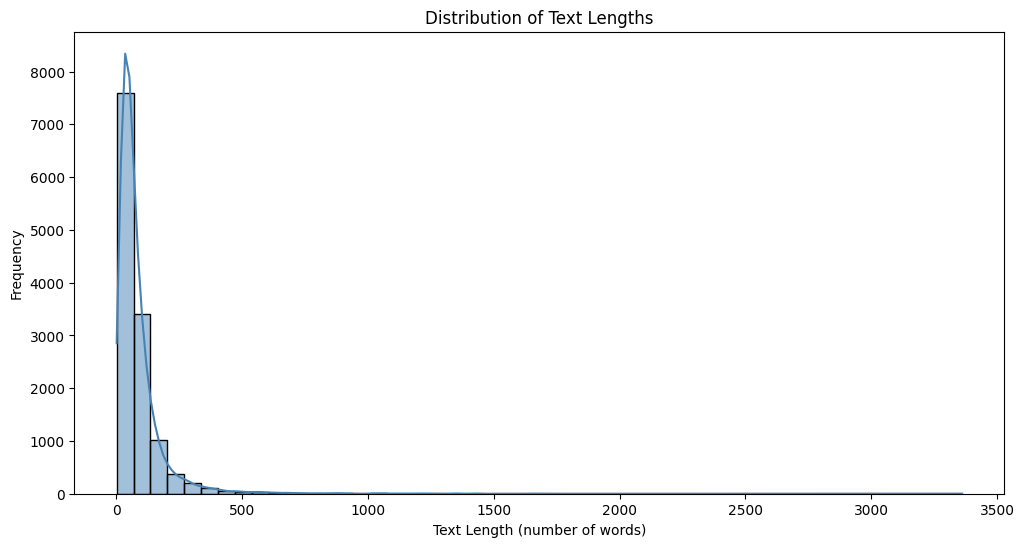

In [94]:
text_lengths = content_df['word_count'].to_list()

# Set up the figure size
plt.figure(figsize=(12, 6))

# Plot the histogram using seaborn with a KDE overlay.
sns.histplot(text_lengths, bins=50, kde=True, color="steelblue")

# Add plot labels and title
plt.title("Distribution of Text Lengths")
plt.xlabel("Text Length (number of words)")
plt.ylabel("Frequency")

# Show the plot
plt.show()

In [95]:
text_lengths_lt_300 = [x for x in text_lengths if x <= 300]
text_lengths_gt_300 = [x for x in text_lengths if x > 300]
text_lengths_gt_500 = [x for x in text_lengths if x > 500]
text_lengths_gt_1000 = [x for x in text_lengths if x > 1000]
text_lengths_gt_2000 = [x for x in text_lengths if x > 2000]
text_lengths_gt_3000 = [x for x in text_lengths if x > 3000]
print("Number posts with below 300 words", len(text_lengths_lt_300))
print("Number posts with over  300 words", len(text_lengths_gt_300))
print("Number posts with over  500 words", len(text_lengths_gt_500))
print("Number posts with over  1000 words", len(text_lengths_gt_1000))
print("Number posts with over  2000 words", len(text_lengths_gt_2000))
print("Number posts with over  3000 words", len(text_lengths_gt_3000))

Number posts with below 300 words 12489
Number posts with over  300 words 386
Number posts with over  500 words 119
Number posts with over  1000 words 26
Number posts with over  2000 words 4
Number posts with over  3000 words 1


In [96]:
## Exploring the data manually
filtered_df = content_df[content_df['word_count'] > 500]
filtered_df.head(150)

content  \
77     Are we heading into another lost decade? In my...   
126    Confusion with support, average cost, and equi...   
187    $HITI : NASDAQ , in-depth and detailed researc...   
221    Why will RDDT not become the next PINS, TWTR, ...   
475    Nvidia: Rising Competition, Valuation Concerns...   
...                                                  ...   
9836   Trading for primary income - Monthly AMA Hey e...   
9942   Mastering Covered Calls: Strategies for Enhanc...   
10103  Options Questions Safe Haven periodic megathre...   
11146  Understanding the Orderbook in R's Quantstrat ...   
12020  Welcome to r/dividends [NEW USERS/BEGINNER INV...   

                                         cleaned_content  \
77     are we heading into another lost decade in my ...   
126    confusion with support average cost and equity...   
187    hiti nasdaq indepth and detailed research the ...   
221    why will rddt not become the next pins twtr sn...   
475    nvidia rising competition valuation concerns a...   
...                                                  ...   
9836   trading for primary income monthly ama hey eve...   
9942   mastering covered calls strategies for enhanci...   
10103  options questions safe haven periodic megathre...   
11146  understanding the orderbook in rs quantstrat e...   
12020  welcome to rdividends new usersbeginner invest...   

                                   cleaned_content_no_sw  \
77     heading another lost decade last post argued p...   
126    confusion support average cost equity value ro...   
187    hiti nasdaq indepth detailed research importan...   
221    rddt become next pins twtr snap social media c...   
475    nvidia rising competition valuation concerns s...   
...                                                  ...   
9836   trading primary income monthly ama hey everyon...   
9942   mastering covered calls strategies enhancing s...   
10103  options questions safe periodic megathread mar...   
11146  understanding orderbook rs quantstrat edit res...   
12020  welcome rdividends new usersbeginner investors...   

                                cleaned_content_lm_no_sw  word_count  
77     heading another lost decade last post argued p...         682  
126    confusion support average cost equity value ro...         553  
187    hiti nasdaq indepth detailed research importan...         566  
221    rddt become next pin twtr snap social medium c...         856  
475    nvidia rising competition valuation concern sh...         697  
...                                                  ...         ...  
9836   trading primary income monthly ama hey everyon...         584  
9942   mastering covered call strategy enhancing stoc...         680  
10103  option question safe periodic megathread march...         576  
11146  understanding orderbook r quantstrat edit resp...         745  
12020  welcome rdividends new usersbeginner investor ...        2288  

[119 rows x 5 columns]

In [97]:
#content_df['cleaned_content_lm_no_sw'].filter(lambda x: x if len(x.split()) > 2000)

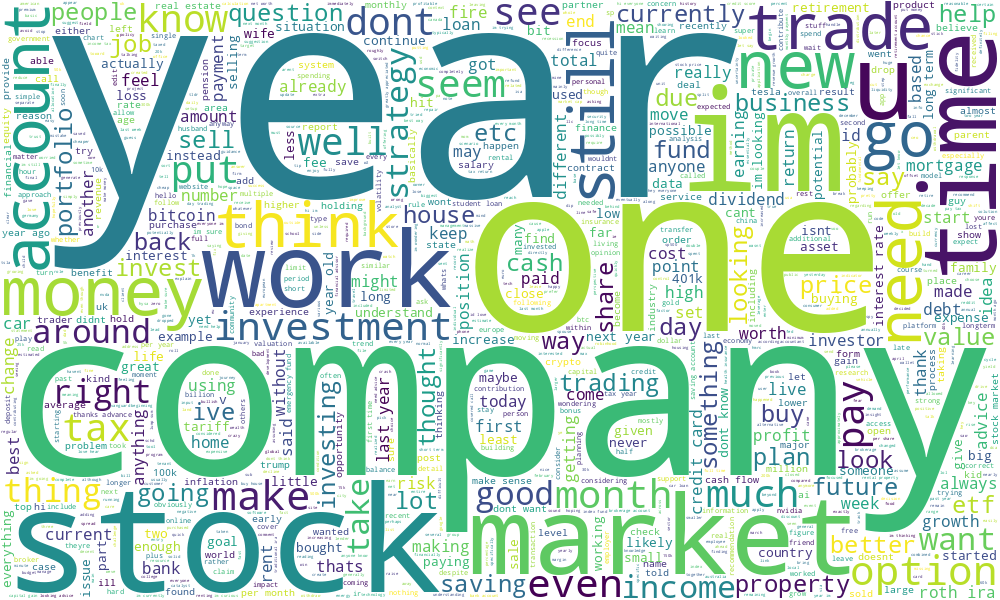

In [98]:
# Import the wordcloud library
from wordcloud import WordCloud

data_words = content_df['cleaned_content_lm_no_sw'].explode().to_list()

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, width=1000, height=600, contour_color='steelblue')

# Generate a big chunck of text
big_chunck_text = " ".join(data_words)

# Generate a word cloud
wordcloud.generate(big_chunck_text)

# Visualize the word cloud
wordcloud.to_image()

** **
## Step 4: Building the Models <a class="anchor\" id="models"></a>
** **

For this tasks, I will be using LDA and Bertopic


In [99]:
# Hyperparameters
n_components = 10
n_top_words = 10
max_top_words = 100

** **
### Latent Dirichlet Allocation (LDA) <a class="anchor\" id="lda"></a>
** **
LDA is all about probabilities. It looks at
how likely words are to appear together, across the entire collection of posts. LDA is
especially good for handling large amounts of data and capturing the natural overlap in
language. For example, words like "stocks", "market", "investments", "money" and "trading" might appear in posts about very different aspects of finance and investment instruments. LDA is good at recognising such overlaps and sorting the words into topics that reflect the complex nature of people’s discussions and views of the financial market


In [100]:
# Hyperparameters for LDA
max_df = 0.9
min_df = 4
max_features = 10000

tf_vectorizer = CountVectorizer(max_df=max_df, min_df=min_df, max_features=max_features, stop_words="english")

tf = tf_vectorizer.fit_transform(content_df['cleaned_content_lm_no_sw'])

lda_model = LatentDirichletAllocation(n_components=n_components, learning_method="online", random_state=100)

lda_model.fit(tf)

LatentDirichletAllocation(learning_method='online', random_state=100)

** **
###  BERTopic Model <a class="anchor\" id="bert_model"></a>
** **
BERTopic is based on the popular language model BERT (Bidirectional Encoder Representations from Transformers), which is trained on a large corpus of text data to understand the context and meaning of words. Unlike LDA, which is based solely on word probabilities and co-occurrence, BERTopic uses language embeddings to understand the context and relationships between words. For example, in finance-related posts, words like "stocks", "market", "investments", "money", and "trading" might appear in different discussions. BERTopic groups these words into topics that capture the subtle overlaps and diverse aspects of financial language.



In [101]:
# Use UMAP to reduce the dimension of the embeddings
# n_components should not be mistaken with number of topics
# n_components is the dimension to reduce the vector to
# min_dist = 0.5 Controls how tightly UMAP packs points together in the low-dimensional space
# metric='cosine'
umap_model = UMAP(n_components=n_components, min_dist=0.5, metric='cosine', random_state=100)

# Use KMeans with n_clusters=n_components i.e number of topics
kmeans_model = KMeans(n_clusters=n_components, random_state=100)

# Using SentenceTransformer and "all-MiniLM-L6-v2" pretrained model
model = SentenceTransformer("all-MiniLM-L6-v2")

# Initialize the model
topic_model = BERTopic(embedding_model=model, umap_model=umap_model, hdbscan_model=kmeans_model, top_n_words=max_top_words)

topics, probs = topic_model.fit_transform(content_df['cleaned_content_lm_no_sw'])

** **
## Step 5: Results and Visualization <a class="anchor\" id="results"></a>
** **
The following visualisations show how the topics were made, they include bar graphs to show top words, word cloud that shows the most prominent words per topic. Dendrogram diagrams that show the relationship between topics and similarity matrices that show the similarity between topics.


In [102]:
# Function to plot the dendrogram
def plot_dendrogram(topic_word_matrix, name):
    dist_matrix = cosine_distances(topic_word_matrix)
    linkage_matrix = linkage(dist_matrix, method='ward')
    # Plot dendrogram
    plt.figure(figsize=(12, 6))
    dendrogram(linkage_matrix, labels=[f"Topic {i + 1}" for i in range(n_components)])
    plt.title(f"Hierarchical Clustering of {name} Topics")
    plt.xlabel("Topic")
    plt.ylabel("Cosine Distance")
    plt.tight_layout()
    plt.show()

### Latent Dirichlet Allocation (LDA)

Results and plots for LDA

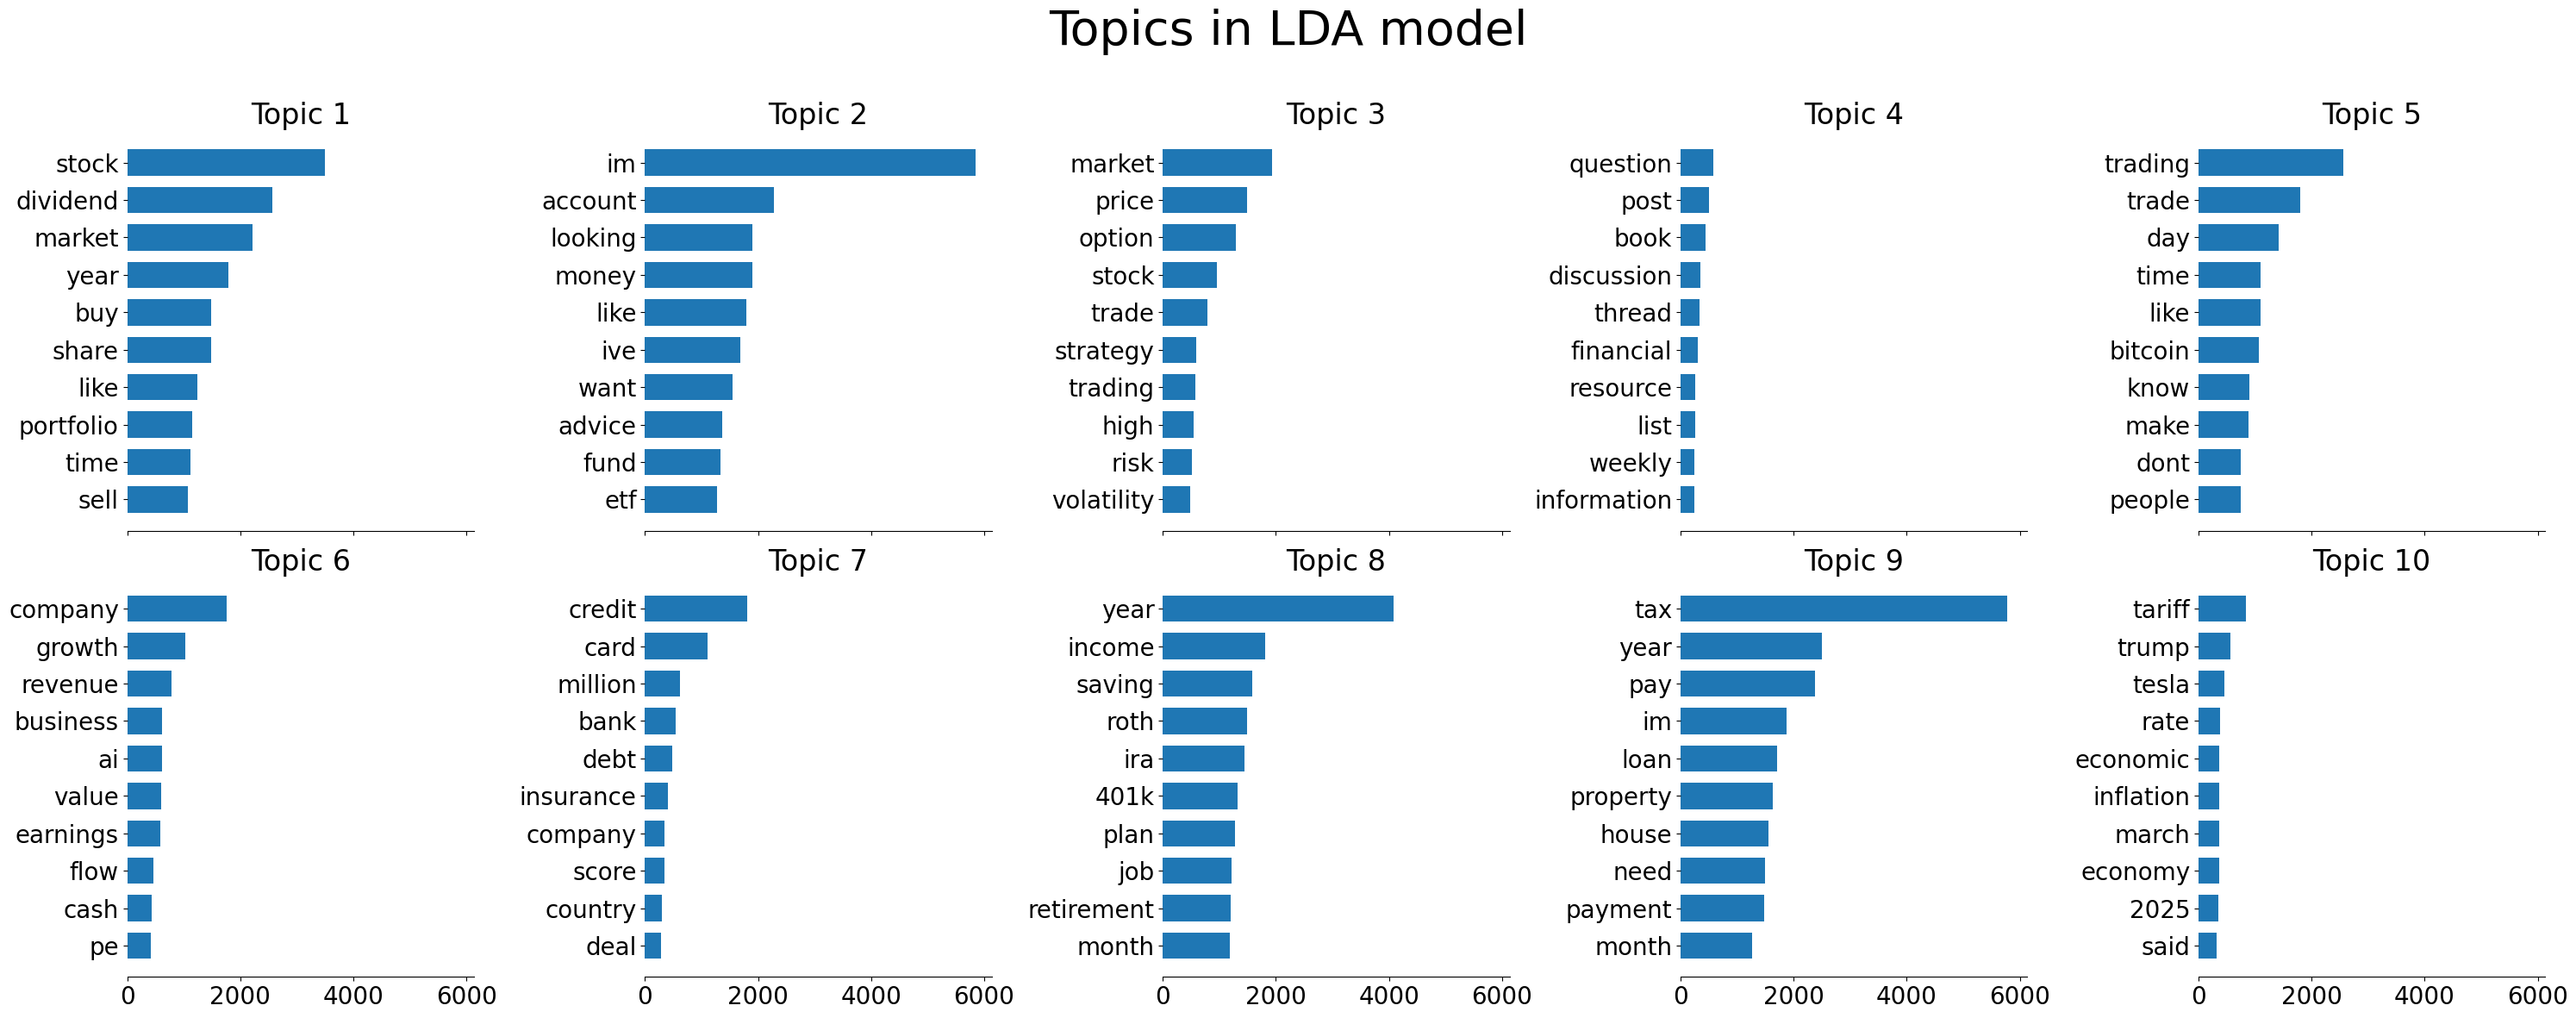

In [103]:
tf_feature_names = tf_vectorizer.get_feature_names_out()

# Adjust layout depending on the number of topics
n_cols = 5
n_rows = (n_components + n_cols - 1) // n_cols

fig, axes = plt.subplots(2, 5, figsize=(30, n_rows * 6), sharex=True)
axes = axes.flatten()
for topic_idx, topic in enumerate(lda_model.components_):
    top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
    top_features = [tf_feature_names[i] for i in top_features_ind]
    weights = topic[top_features_ind]

    ax = axes[topic_idx]
    ax.barh(top_features, weights, height=0.7)
    ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 24})
    ax.invert_yaxis()
    ax.tick_params(axis="both", which="major", labelsize=20)
    ax.tick_params(axis="both", which="major", labelsize=20)
    for side in ["top", "right", "left"]:
        ax.spines[side].set_visible(False)

fig.suptitle("Topics in LDA model", fontsize=40)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

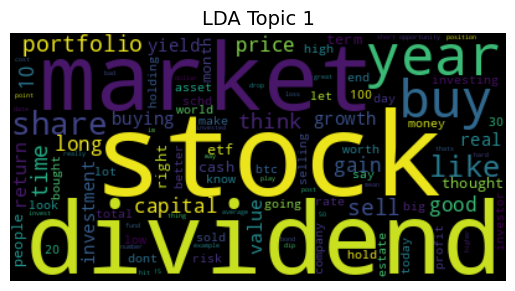

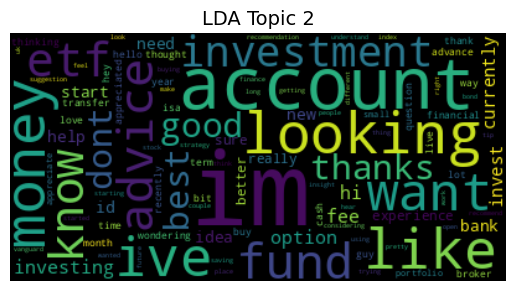

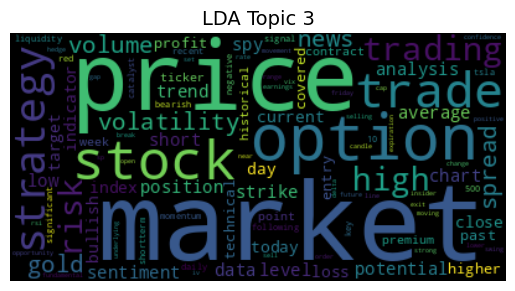

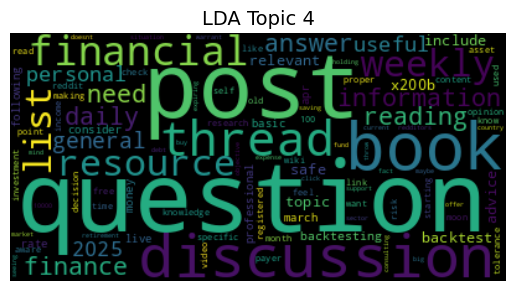

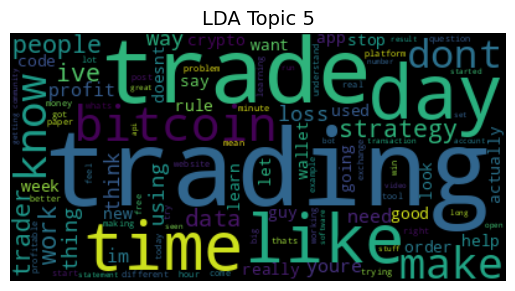

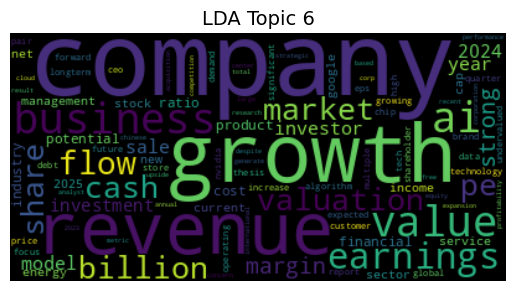

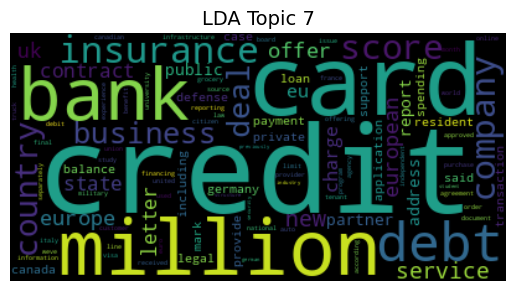

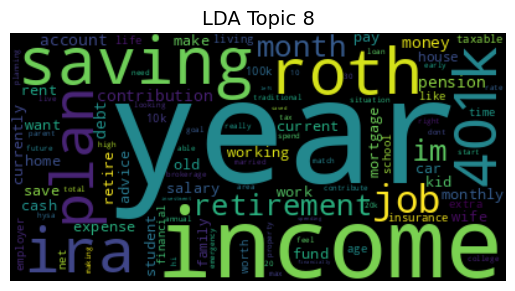

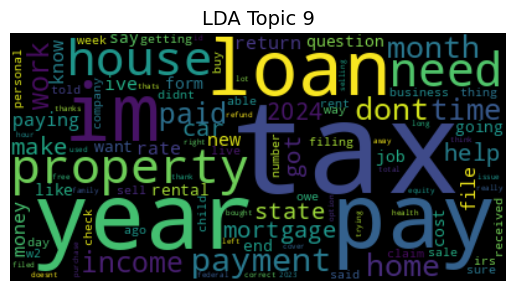

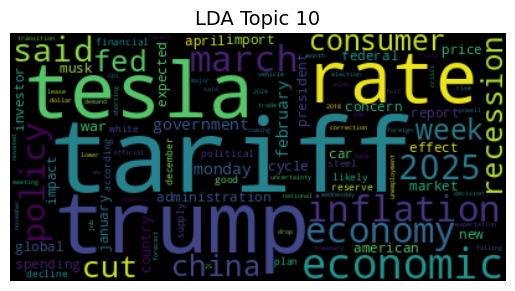

In [104]:
for topic_idx, topic in enumerate(lda_model.components_):
    top_features_ind = topic.argsort()[: -max_top_words - 1 : -1]
    top_features = [tf_feature_names[i] for i in top_features_ind]
    weights = topic[top_features_ind]
    word_freq = dict()
    for i in range(len(top_features)):
        word_freq[top_features[i]] = weights[i]
    wordcloud = WordCloud().generate_from_frequencies(word_freq)
    plt.clf()
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"LDA Topic {topic_idx + 1}", fontsize=14)
    plt.show()
    print("")

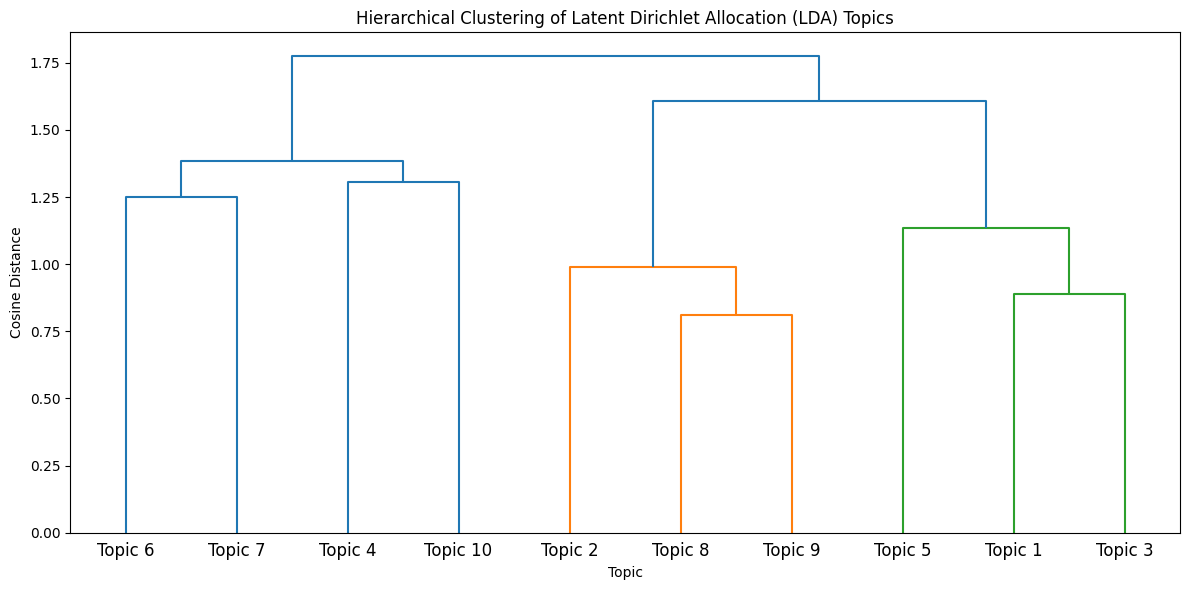

In [105]:
lda_topic_word_matrix = lda_model.components_ / lda_model.components_.sum(axis=1)[:, np.newaxis]
plot_dendrogram(lda_topic_word_matrix, "Latent Dirichlet Allocation (LDA)")

#### Similarity Matrix for LDA

In [ ]:
# Compute pairwise cosine similarity between topics
similarity_matrix = cosine_similarity(lda_topic_word_matrix)

plt.figure(figsize=(10, 8))

# Plot heatmap
sns.heatmap(similarity_matrix, annot=True, cmap='YlGnBu',
            xticklabels=[f'Topic {i + 1}' for i in range(similarity_matrix.shape[0])],
            yticklabels=[f'Topic {i + 1}' for i in range(similarity_matrix.shape[0])])
plt.title('Cosine Similarity Between LDA Topics')
plt.show()

### BERTopic

Results and plots for Bertopics

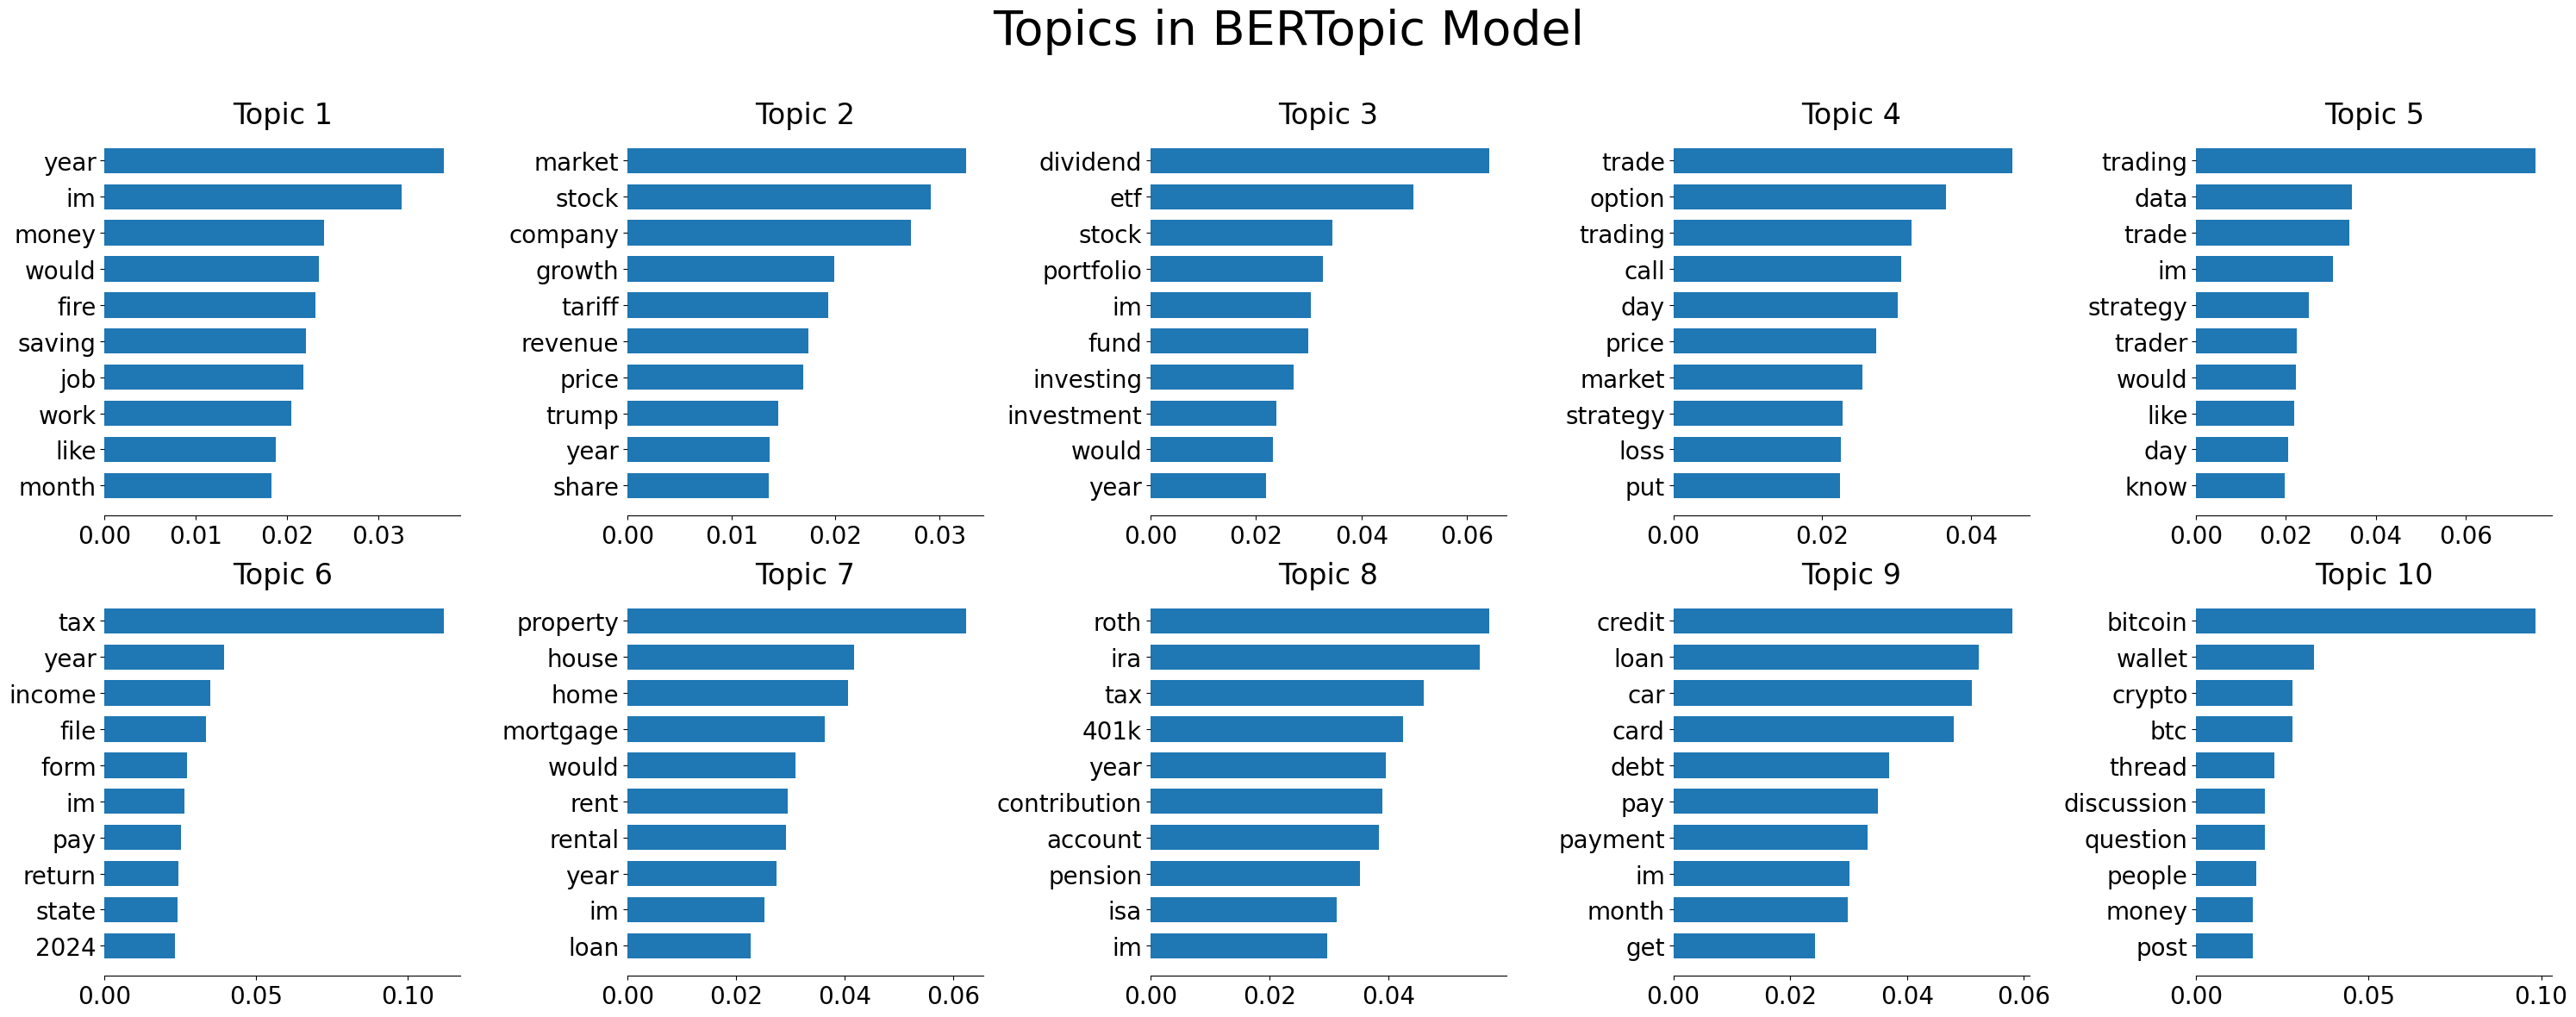

In [106]:
topics = topic_model.get_topics()

# Adjust layout depending on the number of topics
n_cols = 5
n_rows = (n_components + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(30, n_rows * 6), sharex=False)
axes = axes.flatten()

for i, topic_id in enumerate(topics):
    top_words = topic_model.get_topic(topic_id)[:n_top_words]
    words = [word for word, _ in top_words]
    scores = [score for _, score in top_words]
    ax = axes[i]
    ax.barh(words, scores, height=0.7)
    ax.set_title(f"Topic {topic_id + 1}", fontdict={"fontsize": 24})
    ax.invert_yaxis()
    ax.tick_params(axis="both", which="major", labelsize=20)
    for side in ["top", "right", "left"]:
        ax.spines[side].set_visible(False)

fig.suptitle("Topics in BERTopic Model", fontsize=40)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

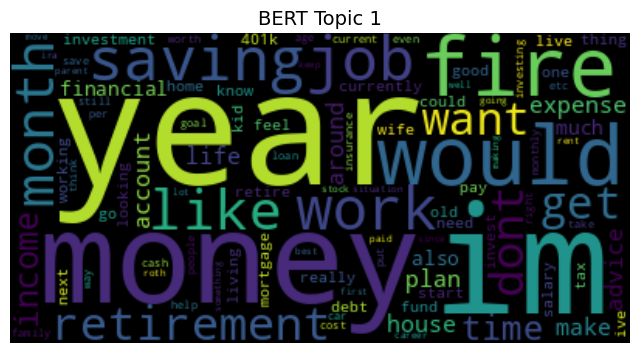

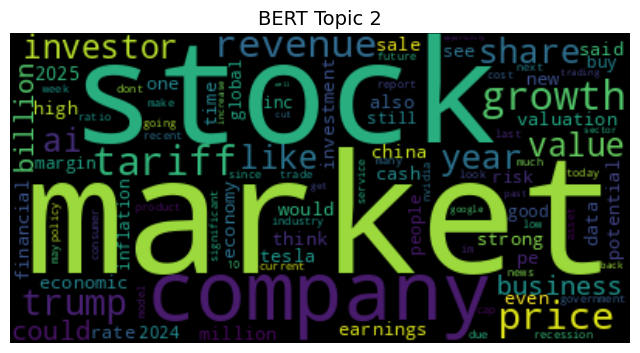

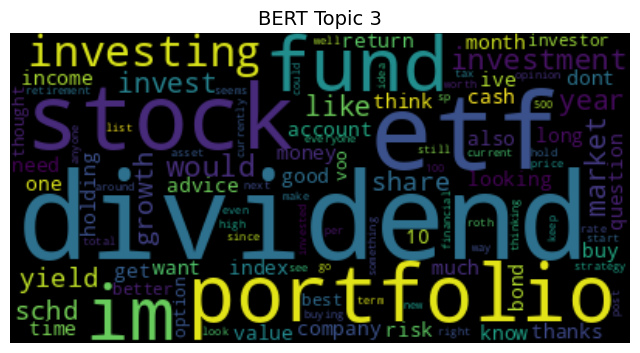

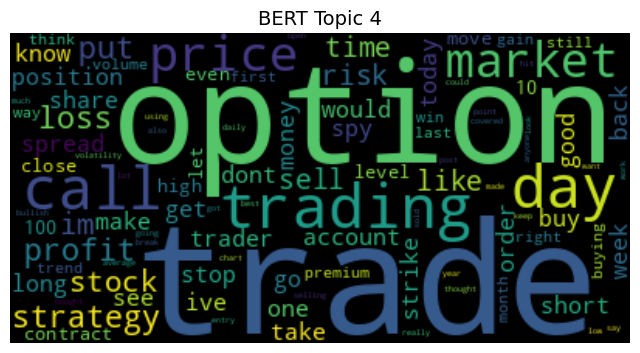

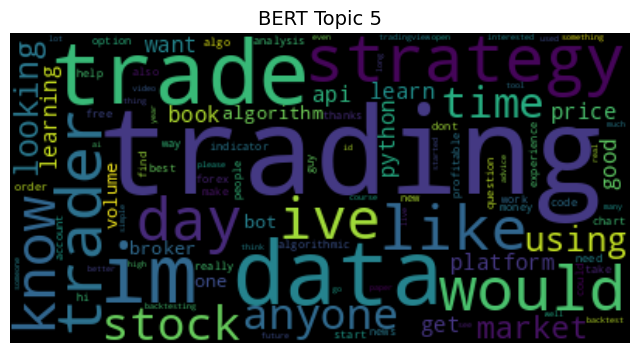

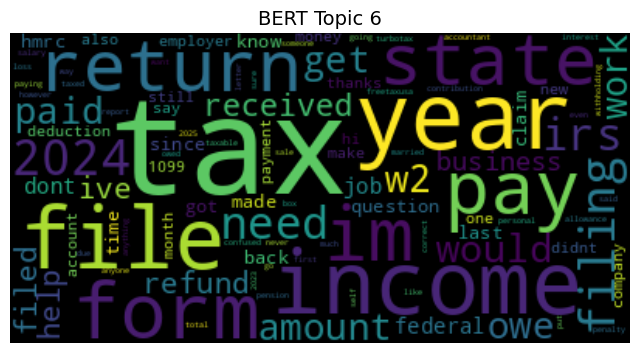

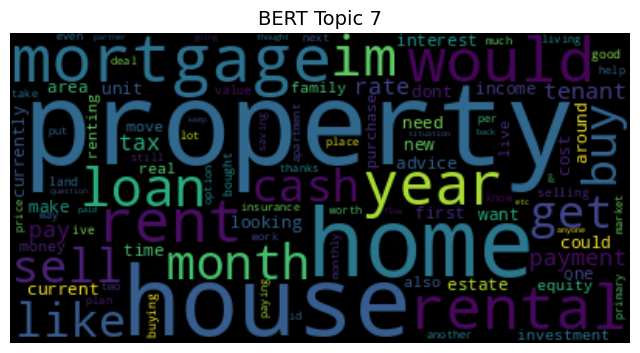

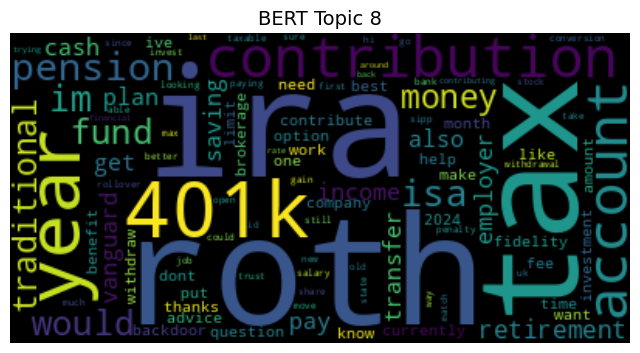

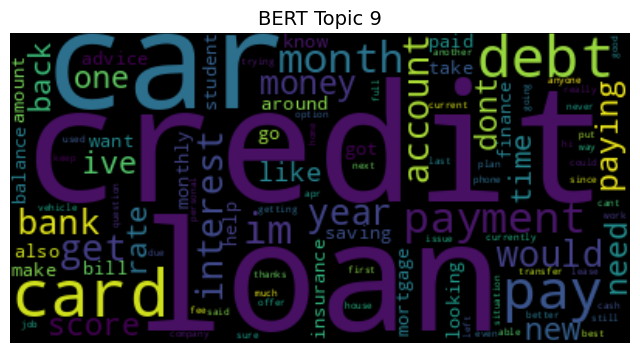

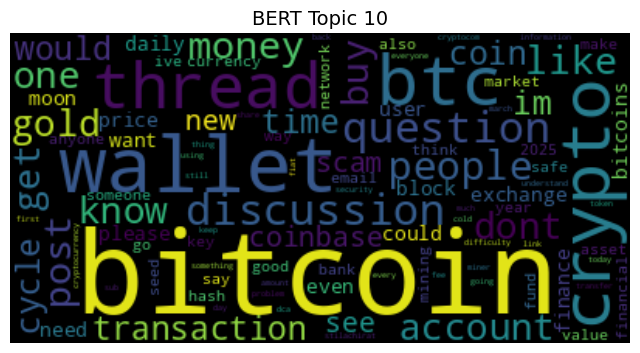

In [107]:
# Assuming topic_model is your BERTopic model
topics = topic_model.get_topics()

for topic_num in topics:
    plt.figure(figsize=(8, 6))
    word_freq = dict(topics[topic_num])
    print("")
    wordcloud = WordCloud().generate_from_frequencies(word_freq)
    plt.clf()
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"BERT Topic {topic_num + 1}", fontsize=14)
    plt.show()

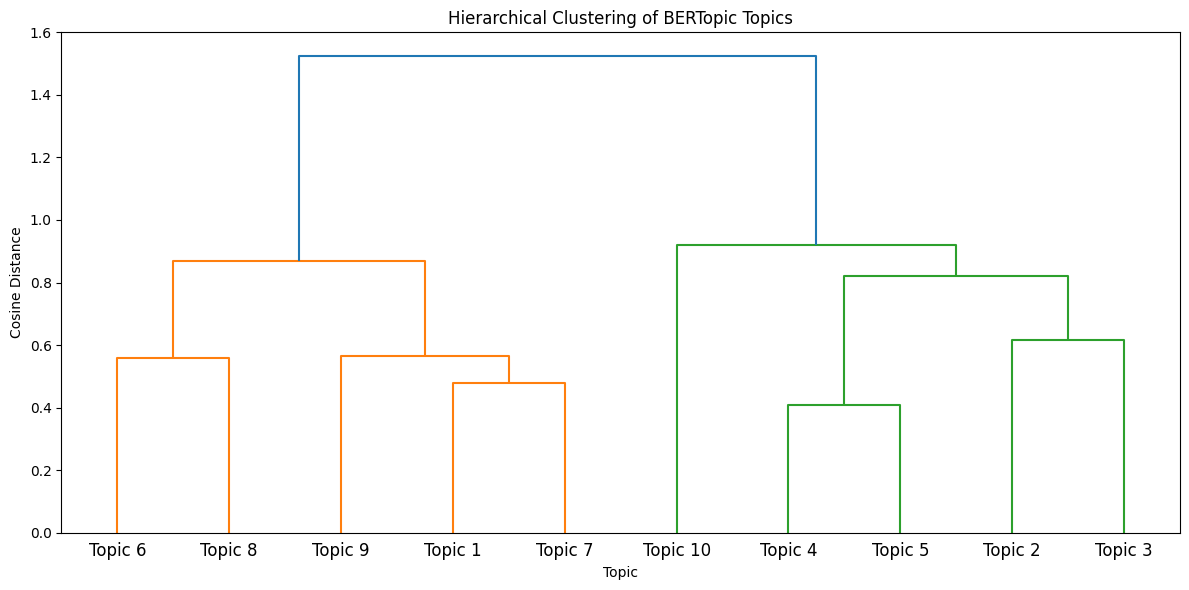

In [108]:
# Hierarchy Plot
# Get topic representations
topic_representations = topic_model.c_tf_idf_.toarray()

# Filter out -1 (outliers) topic if exists
valid_topics = [i for i in range(len(topic_model.get_topic_info())) if i != -1]
bert_topic_word_matrix = topic_representations[valid_topics]


plot_dendrogram(bert_topic_word_matrix, "BERTopic")

#### Similarity Matrix for BERTopic

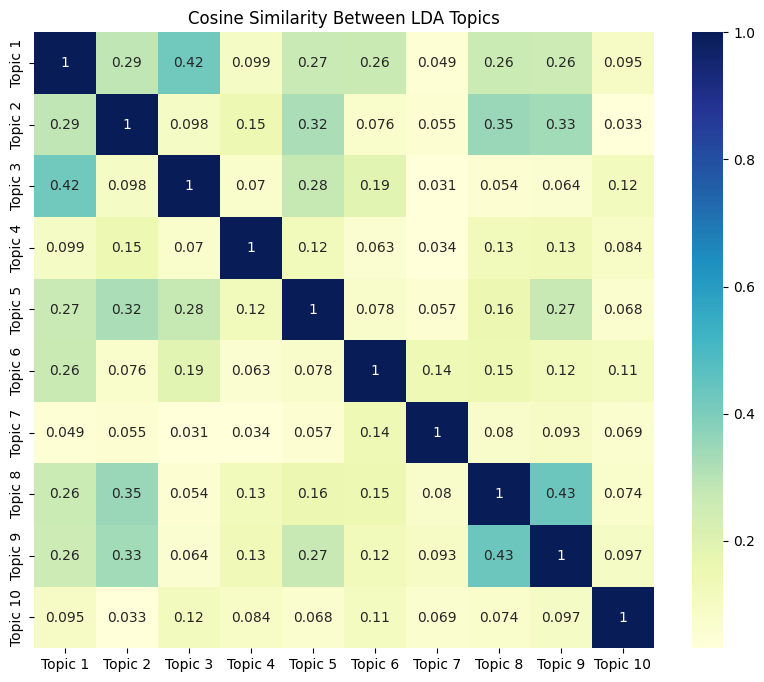

In [111]:
# Compute pairwise cosine similarity between topics
similarity_matrix = cosine_similarity(lda_topic_word_matrix)

plt.figure(figsize=(10, 8))

# Plot heatmap
sns.heatmap(similarity_matrix, annot=True, cmap='YlGnBu',
            xticklabels=[f'Topic {i + 1}' for i in range(similarity_matrix.shape[0])],
            yticklabels=[f'Topic {i + 1}' for i in range(similarity_matrix.shape[0])])
plt.title('Cosine Similarity Between LDA Topics')
plt.show()